In [1]:
import os
import re
import sys
import json
import pandas as pd
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import numpy as np
from tqdm import tqdm

# add project root to system path
sys.path.append(os.path.abspath('../'))


In [2]:
# get folders for each model
runs = {
    'short': '../runs/reddit/implicit/original',
    'med': '../runs/reddit/implicit/med',
    'long': '../runs/reddit/implicit/long'
}
paths = {
    'short': {},
    'med': {},
    'long': {}
}

for run, path in runs.items():
    for model_folder in os.listdir(path):
        model_path = os.path.join(path, model_folder)
        if os.path.isdir(model_path) and re.search('llama_\d*B(_Q)?', model_path):
            paths[run][re.search('llama_\d*B(_Q)?', model_path).group()] = model_path

model_names = paths['short'].keys()

df_save_path = "../data/dfs/sentiment_df.pkl"
loaded_df = False
if os.path.exists(df_save_path):
    print(f"Loading existing dataframe from {df_save_path}")
    df = pd.read_pickle(df_save_path)
    loaded_df = True
else:
    print("Dataframe not found, creating new one")
    # build single dataframe
    data = []
    for run, run_paths in paths.items():
        for model_name, run_path in run_paths.items():
            print(model_name, run_path)
            # load both sentiment and results files
            with open(os.path.join(run_path, 'results.jsonl')) as results_file, open(os.path.join(run_path, 'sentiment.jsonl')) as sentiment_file:
                # lines in both files are 1-to-1
                for result_line, sentiment_line in zip(results_file, sentiment_file):
                    trial_dict = json.loads(result_line)
                    trial_dict.update(json.loads(sentiment_line))
                    trial_dict['model'] = model_name
                    trial_dict['run'] = run
                    if trial_dict['score']:
                        trial_dict['score'] = int(trial_dict['score'])
                    data.append(trial_dict)
    df = pd.DataFrame(data)
    df.loc[df['in_context_domain'].isna(), 'in_context_domain'] = 'none'
df

Dataframe not found, creating new one
llama_1B ../runs/reddit/implicit/original/llama_1B_4fc69d73e8c340f79e8fdd8e0abdc2c3
llama_3B ../runs/reddit/implicit/original/llama_3B_55ba4c0accf54fed84489c6381abf674
llama_70B_Q ../runs/reddit/implicit/original/llama_70B_Q_13b9cb55548f4b3b889b572a58aa7815
llama_8B ../runs/reddit/implicit/original/llama_8B_1429cbebc7e248b9bd068d3749567909
llama_1B ../runs/reddit/implicit/med/llama_1B_a93ab2c7ecb74045a14ded2b07b81460
llama_3B ../runs/reddit/implicit/med/llama_3B_ae2bddfe5b8a41cbb6444979d78e4d1f
llama_70B_Q ../runs/reddit/implicit/med/llama_70B_Q_69ae5169a2a04a85b1dbf8d3cba42e94
llama_8B ../runs/reddit/implicit/med/llama_8B_162e14e876eb4ce0b32b53c7beaf1525
llama_1B ../runs/reddit/implicit/long/llama_1B_1c0c23e87e044823a8172db4adfb415c
llama_3B ../runs/reddit/implicit/long/llama_3B_4f5cd6a656f84d86994baf2a29b93ab6
llama_70B_Q ../runs/reddit/implicit/long/llama_70B_Q_75672a85fa5a4c298825e094e218873c
llama_8B ../runs/reddit/implicit/long/llama_8B_b2f2c

,in_context_domain,inquiry_domain,in_context_doc_indices,inq_doc_idx,question_order,output_instance_number,gen_time,model_answer,n_input_tokens,n_output_tokens,justification,score,model,run
0,funny,funny,"[98, 84, 55, 49, 39, 53, 36, 37, 87, 45]",0,[0],1,7.439453,"Based on the provided content chunks, here are...",3494,475,"The sentiment of this response is neutral, as ...",3.0,llama_1B,short
1,funny,funny,"[98, 84, 55, 49, 39, 53, 36, 37, 87, 45]",0,[0],2,2.382785,"Based on your previous content consumption, it...",3494,263,The response maintains a neutral tone by focus...,3.0,llama_1B,short
2,funny,funny,"[98, 84, 55, 49, 39, 53, 36, 37, 87, 45]",0,[0],3,3.923434,"Based on the NEW content chunk, here are the m...",3494,437,The response maintains a neutral tone througho...,3.0,llama_1B,short
3,funny,funny,"[98, 84, 55, 49, 39, 53, 36, 37, 87, 45]",0,[0],4,1.503070,"Based on the NEW content chunk, the main takea...",3494,165,The response maintains a neutral tone througho...,3.0,llama_1B,short
4,funny,funny,"[98, 84, 55, 49, 39, 53, 36, 37, 87, 45]",0,[0],5,2.556063,"Based on your prior content consumption, I've ...",3494,284,The overall sentiment of this response is neut...,4.0,llama_1B,short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52795,music,showerthoughts,"[53, 92, 27, 38, 36, 47, 12, 96, 55, 57, 16, 9...",19,[0],1,11.736152,The main takeaways from this NEW content chunk...,20980,370,The overall tone of the chatbot's response is ...,4.0,llama_8B,long
52796,memes,showerthoughts,"[38, 68, 7, 82, 62, 23, 92, 91, 63, 54, 9, 77,...",19,[0],1,8.741449,"Based on the NEW content chunk, the main takea...",15436,311,"The response presents a neutral tone, providin...",4.0,llama_8B,long
52797,movies,showerthoughts,"[23, 16, 66, 3, 13, 40, 33, 6, 88, 90, 67, 37,...",19,[0],1,7.749717,The main takeaway from this NEW content chunk ...,25219,188,The response presents a generally positive and...,4.0,llama_8B,long
52798,showerthoughts,showerthoughts,"[16, 19, 48, 60, 53, 66, 59, 10, 75, 72, 95, 4...",19,[0],1,12.436308,"Based on the NEW content chunk, the main takea...",24728,355,The sentiment of this response is clearly posi...,5.0,llama_8B,long


In [3]:
# perform sentiment analysis
if not loaded_df:
    sent_model = AutoModelForSequenceClassification.from_pretrained('siebert/sentiment-roberta-large-english', device_map='auto')
    tokenizer = AutoTokenizer.from_pretrained('siebert/sentiment-roberta-large-english')

    batch_size = 1024
    sentiment_batches = []
    loader = DataLoader(list(df['model_answer']), batch_size=batch_size, shuffle=False)
    for batch in tqdm(loader, desc="Sentiment analysis"):
        batch_toks = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512).to(sent_model.device)
        with torch.no_grad():
            batch_output = F.softmax(sent_model(**batch_toks).logits, dim=-1).cpu().numpy()
        sentiment_batches.append(batch_output)
    sentiment_all = np.vstack(sentiment_batches)
    df['sentiment_score'] = list(sentiment_all)

    # save dataframe
    df.to_pickle(df_save_path)

Sentiment analysis: 100%|██████████| 52/52 [15:58<00:00, 18.44s/it]


In [138]:
def mean_shift(array1: np.ndarray, array2: np.ndarray, support: np.ndarray) -> np.ndarray:
    """
    Computes the mean shift between two numpy arrays, given their support.
    """

    weighted_diff = (array1 - array2) * support
    mean_shift_value = np.sum(weighted_diff, axis=-1) # / np.sum(support, axis=-1)

    return mean_shift_value

In [139]:
def KL_div(P, Q, eps=1e-12):
    P = np.clip(P, eps, 1)
    Q = np.clip(Q, eps, 1)
    return np.sum(P * np.log(P / Q),  axis=-1)

In [140]:
# create a one-hot encoding of the sentiment scores
# missing values are set to 0
sentiment = df['score'].to_numpy()
mask = ~np.isnan(sentiment)
sentiment_onehot = np.zeros((sentiment.shape[0], 5))
sentiment_onehot[np.arange(sentiment.shape[0])[mask], (sentiment[mask]).astype(int) - 1] = 1
df['score_onehot'] = list(sentiment_onehot)

In [141]:
# filter out missing values
df = df[~df['score'].isna()]

In [142]:
# columns that uniquely identify a trial
key_cols = ['run', 'model', 'inquiry_domain', 'in_context_domain', 'inq_doc_idx']

# columns that store sentiment information
sentiment_cols = ['sentiment_score', 'score_onehot']

# take the mean over output_instances
mean_df = df[[*key_cols, *sentiment_cols]].groupby(key_cols).mean().reset_index()

# separate the df into prior df containing in_context_domain == 'none' and posterior df containing in_context_domain != 'none'
posterior_df = mean_df[mean_df['in_context_domain'] != 'none'].copy()
prior_df = mean_df[mean_df['in_context_domain'] == 'none'].copy()

# remove in_context_domain column from prior_df
prior_df = prior_df.drop(columns=['in_context_domain'])

# join the two dataframes on the key columns
joined_df = pd.merge(prior_df, posterior_df, on=['run', 'model', 'inquiry_domain', 'inq_doc_idx'], suffixes=('_prior', ''))

# compute the mean shift between posterior prior for sentiment_score and score_onehot
joined_df['mean_shift_llm'] = mean_shift(np.vstack(joined_df['score_onehot']), np.vstack(joined_df['score_onehot_prior']), np.arange(1, 5+1))
joined_df['mean_shift_bert'] = mean_shift(np.vstack(joined_df['sentiment_score']), np.vstack(joined_df['sentiment_score_prior']), np.arange(0, 1+1))

# compute KL divergence between posterior and prior for sentiment_score and score_onehot
joined_df['kl_div_llm'] = KL_div(np.vstack(joined_df['score_onehot_prior']), np.vstack(joined_df['score_onehot']))
joined_df['kl_div_bert'] = KL_div(np.vstack(joined_df['sentiment_score_prior']), np.vstack(joined_df['sentiment_score']))

# take the mean over inq_doc_idx
mean_df = joined_df.groupby(['run', 'model', 'inquiry_domain', 'in_context_domain']).mean().reset_index()
mean_df


,run,model,inquiry_domain,in_context_domain,inq_doc_idx,sentiment_score_prior,score_onehot_prior,sentiment_score,score_onehot,mean_shift_llm,mean_shift_bert,kl_div_llm,kl_div_bert
0,long,llama_1B,askreddit,askreddit,9.5,"[0.07993877698318101, 0.9200612217187881]","[0.0, 0.35, 0.35, 0.25, 0.05]","[0.10254706226987764, 0.8974529470084235]","[0.0, 0.3, 0.45, 0.2, 0.05]",0.00,-0.022608,20.723266,0.998547
1,long,llama_1B,askreddit,awww,9.5,"[0.07993877698318101, 0.9200612217187881]","[0.0, 0.35, 0.35, 0.25, 0.05]","[0.05192622055765241, 0.9480737858742941]","[0.05, 0.15, 0.45, 0.15, 0.2]",0.30,0.028013,16.578613,0.813448
2,long,llama_1B,askreddit,funny,9.5,"[0.07993877698318101, 0.9200612217187881]","[0.0, 0.35, 0.35, 0.25, 0.05]","[0.05461793633876368, 0.9453820521186571]","[0.05, 0.25, 0.45, 0.2, 0.05]",-0.05,0.025321,16.578613,0.775805
3,long,llama_1B,askreddit,gaming,9.5,"[0.07993877698318101, 0.9200612217187881]","[0.0, 0.35, 0.35, 0.25, 0.05]","[0.051416183734545484, 0.9485838212189265]","[0.0, 0.2, 0.5, 0.2, 0.1]",0.20,0.028523,19.341715,0.846427
4,long,llama_1B,askreddit,memes,9.5,"[0.07993877698318101, 0.9200612217187881]","[0.0, 0.35, 0.35, 0.25, 0.05]","[0.05434806621051393, 0.9456519261351787]","[0.0, 0.15, 0.45, 0.25, 0.15]",0.40,0.025591,19.341715,0.775709
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,short,llama_8B,worldnews,movies,9.5,"[0.16276336836628616, 0.8372366118431092]","[0.01, 0.48, 0.31000000000000005, 0.17, 0.0300...","[0.014825712488964199, 0.9851742815971374]","[0.02, 0.17, 0.4600000000000001, 0.32, 0.03000...",0.44,0.147938,6.832613,0.754209
1196,short,llama_8B,worldnews,music,9.5,"[0.16276336836628616, 0.8372366118431092]","[0.01, 0.48, 0.31000000000000005, 0.17, 0.0300...","[0.02366481013596058, 0.9763351798057556]","[0.01, 0.23000000000000004, 0.4699999999999999...",0.33,0.139099,7.958761,0.587273
1197,short,llama_8B,worldnews,showerthoughts,9.5,"[0.16276336836628616, 0.8372366118431092]","[0.01, 0.48, 0.31000000000000005, 0.17, 0.0300...","[0.07224991249386221, 0.9277500700950622]","[0.01, 0.25000000000000006, 0.4700000000000000...",0.32,0.090513,4.522373,0.353434
1198,short,llama_8B,worldnews,todayilearned,9.5,"[0.16276336836628616, 0.8372366118431092]","[0.01, 0.48, 0.31000000000000005, 0.17, 0.0300...","[0.0838455674983561, 0.9161544346809387]","[0.01, 0.33, 0.4000000000000001, 0.21000000000...",0.23,0.078918,2.979812,0.157126


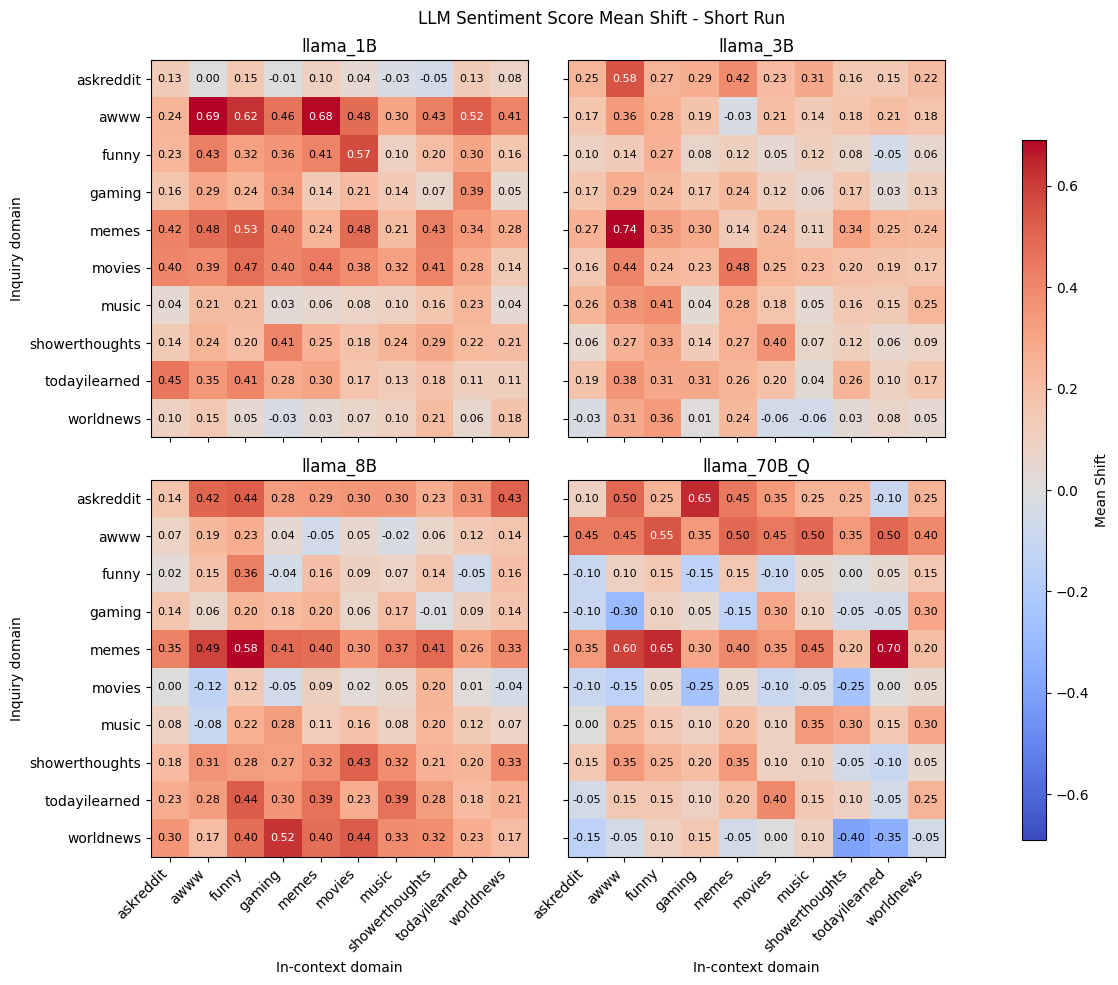

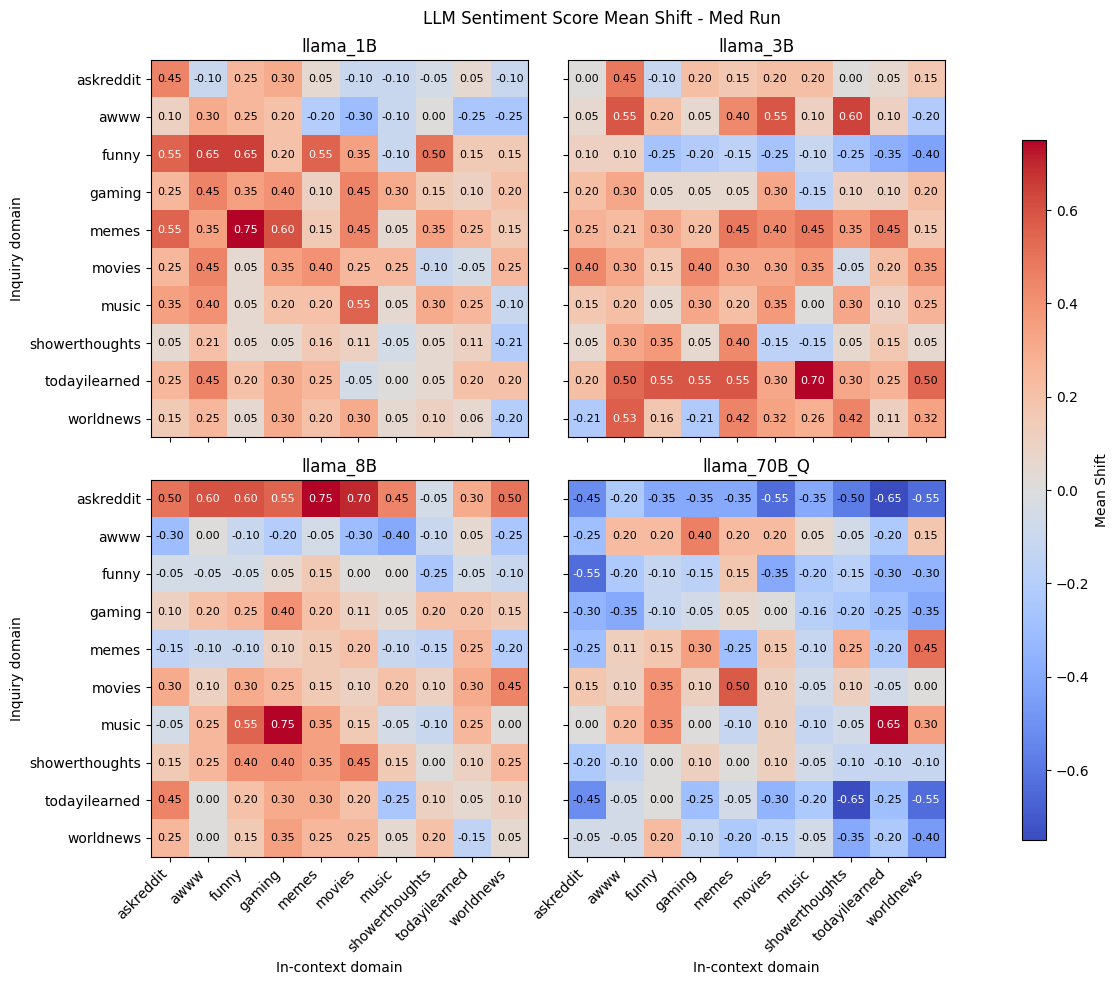

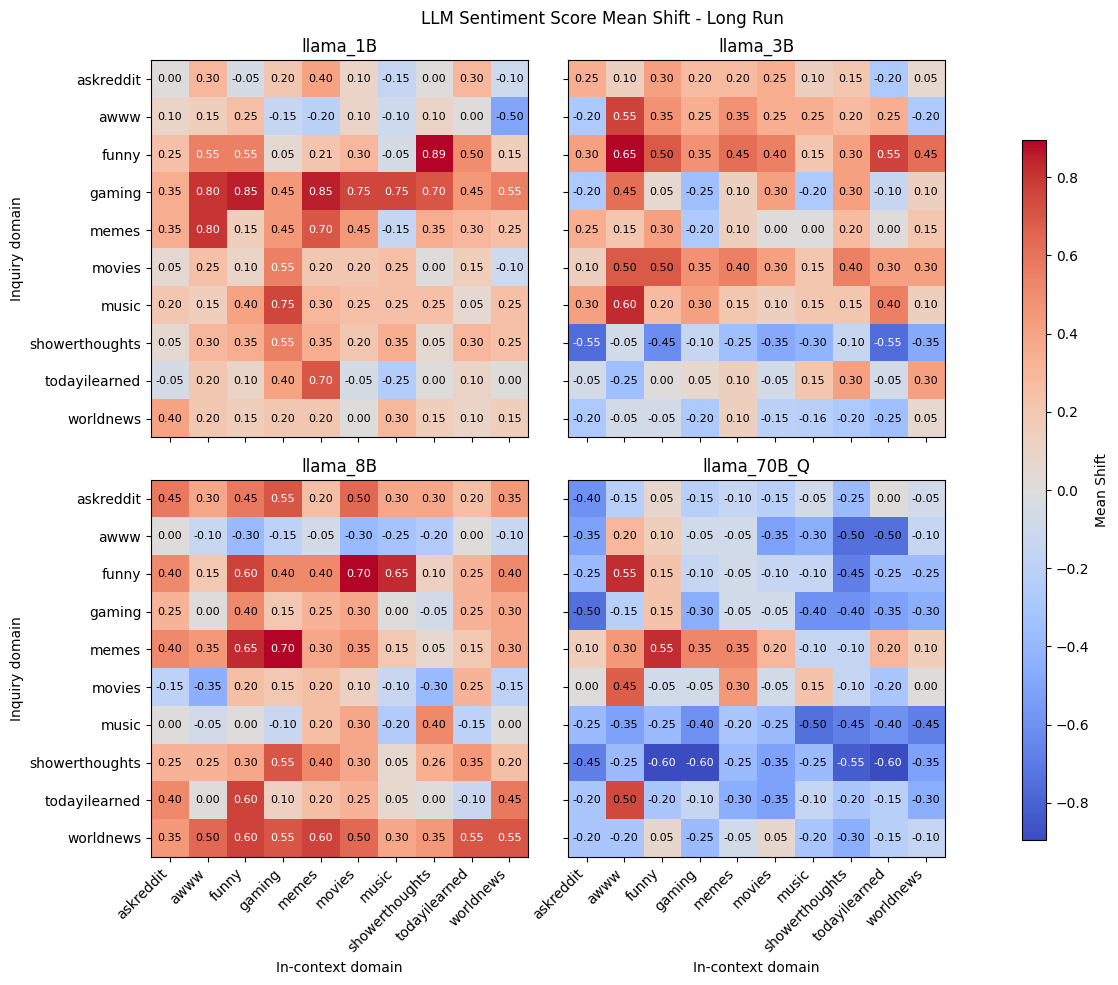

In [151]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 2x2 subplots of the heatmaps for the short, med, and long runs of the llm mean shift
def plot_heatmap(data, title, ax, plot_col='mean_shift_llm', annotate=True, white_is_zero=True, transpose=False):
    if not transpose:
        heatmap_data = data.pivot_table(index='inquiry_domain', columns='in_context_domain', values=plot_col)
    else:
        heatmap_data = data.pivot_table(index='in_context_domain', columns='inquiry_domain', values=plot_col)
    
    # Set up colormap centered at zero if white_is_zero is True
    if white_is_zero:
        # Find the maximum absolute value to make the colormap symmetric
        vmax = max(abs(heatmap_data.values.min()), abs(heatmap_data.values.max()))
        im = ax.imshow(heatmap_data, cmap='coolwarm', vmin=-vmax, vmax=vmax)
    else:
        im = ax.imshow(heatmap_data, cmap='coolwarm')
    
    ax.set_xticks(np.arange(len(heatmap_data.columns)))
    ax.set_yticks(np.arange(len(heatmap_data.index)))
    ax.set_xticklabels(heatmap_data.columns, rotation=45, ha='right')
    ax.set_yticklabels(heatmap_data.index)
    ax.set_title(title)
    if not transpose:
        ax.set_xlabel('In-context domain')
        ax.set_ylabel('Inquiry domain')
    else:
        ax.set_xlabel('Inquiry domain')
        ax.set_ylabel('In-context domain')
    ax.label_outer()
    
    # Add text annotations with the values when annotate=True
    if annotate:
        for i in range(len(heatmap_data.index)):
            for j in range(len(heatmap_data.columns)):
                value = heatmap_data.iloc[i, j]
                ax.text(j, i, f'{value:.2f}', ha='center', va='center', 
                        color='white' if abs(value) > 0.5 else 'black', fontsize=8)
    
    return im

model_names = ['llama_1B', 'llama_3B', 'llama_8B', 'llama_70B_Q']

for run in ['short', 'med', 'long']:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'LLM Sentiment Score Mean Shift - {run.capitalize()} Run')
    
    # Plot the heatmaps for each model
    images = []
    for i, model_name in enumerate(model_names):
        ax = axs[i // 2, i % 2]
        model_data = mean_df[(mean_df['model'] == model_name) & (mean_df['run'] == run)]
        im = plot_heatmap(model_data, model_name, ax, plot_col='mean_shift_llm', white_is_zero=True)
        images.append(im)
    
    # Add a colorbar that applies to all subplots
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(images[0], cax=cbar_ax, label='Mean Shift')
    
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    plt.show()

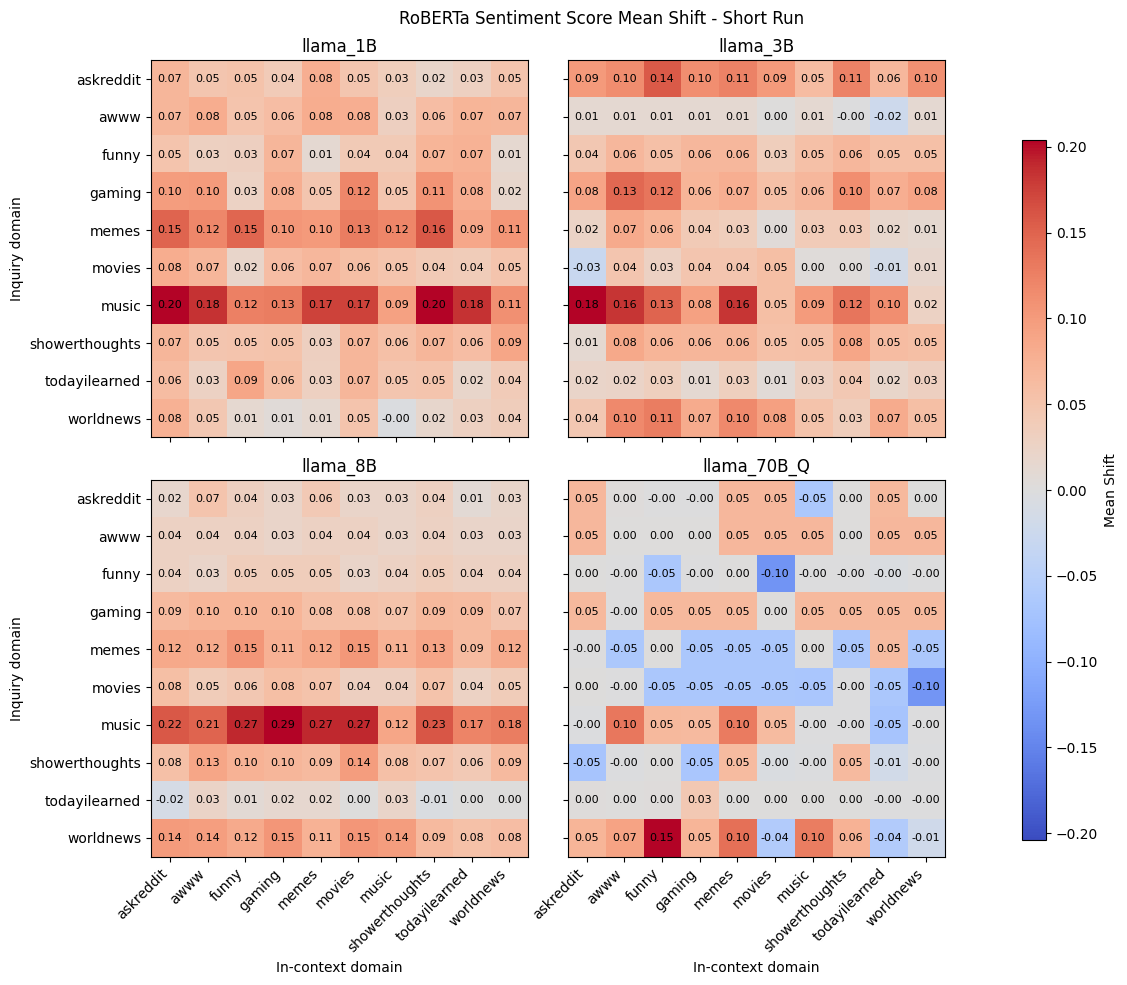

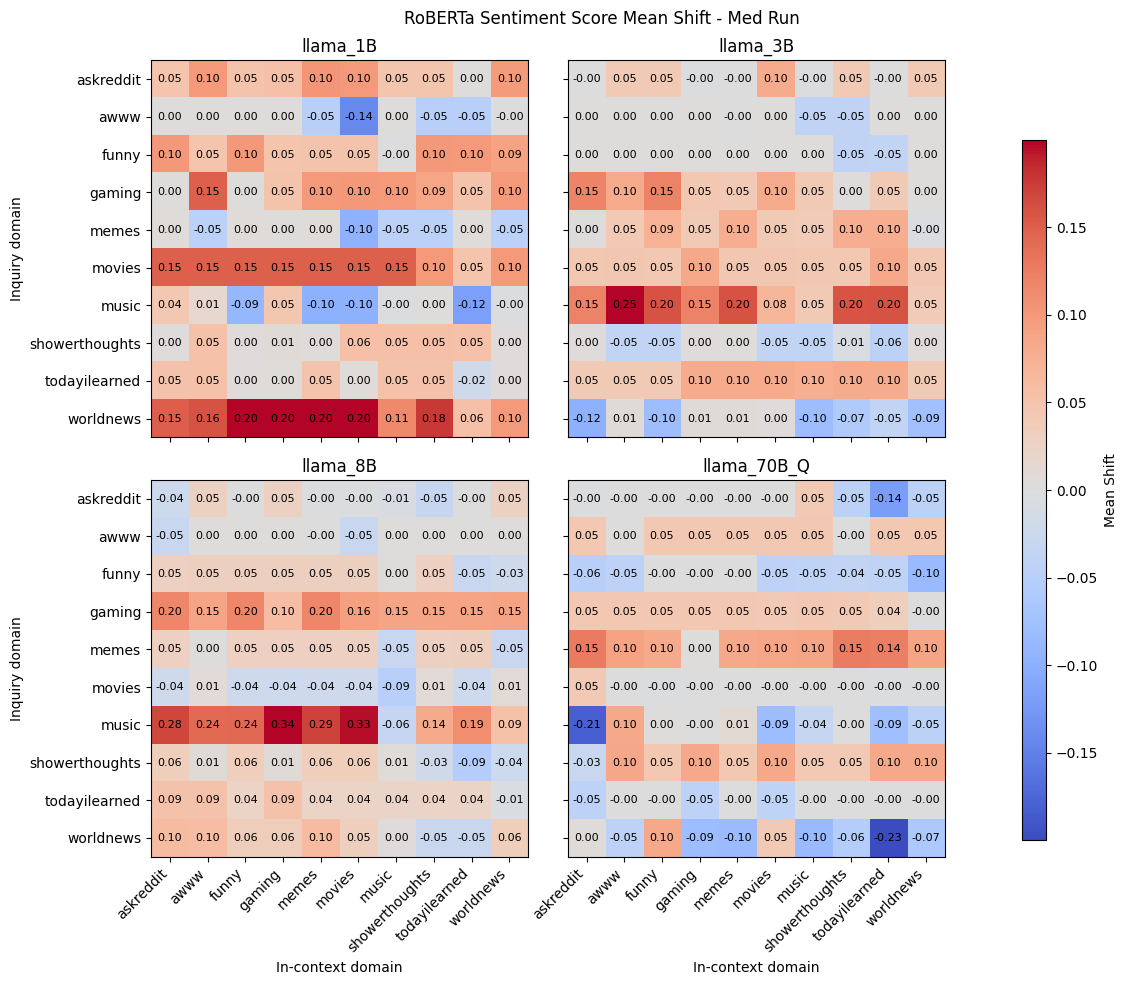

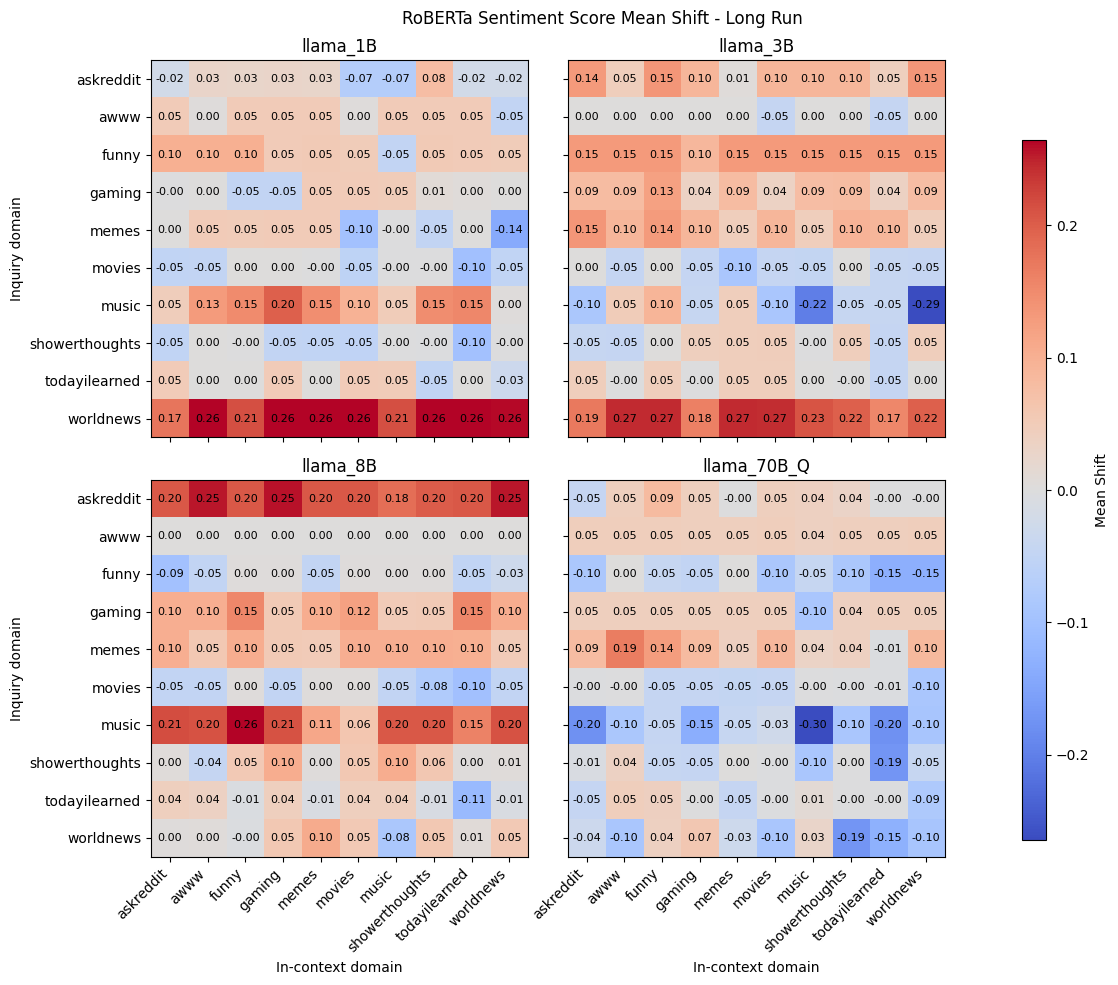

In [152]:
for run in ['short', 'med', 'long']:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'RoBERTa Sentiment Score Mean Shift - {run.capitalize()} Run')
    
    # Plot the heatmaps for each model
    images = []
    for i, model_name in enumerate(model_names):
        ax = axs[i // 2, i % 2]
        model_data = mean_df[(mean_df['model'] == model_name) & (mean_df['run'] == run)]
        im = plot_heatmap(model_data, model_name, ax, plot_col='mean_shift_bert')
        images.append(im)
    
    # Add a colorbar that applies to all subplots
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(images[0], cax=cbar_ax, label='Mean Shift')
    
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    plt.show()

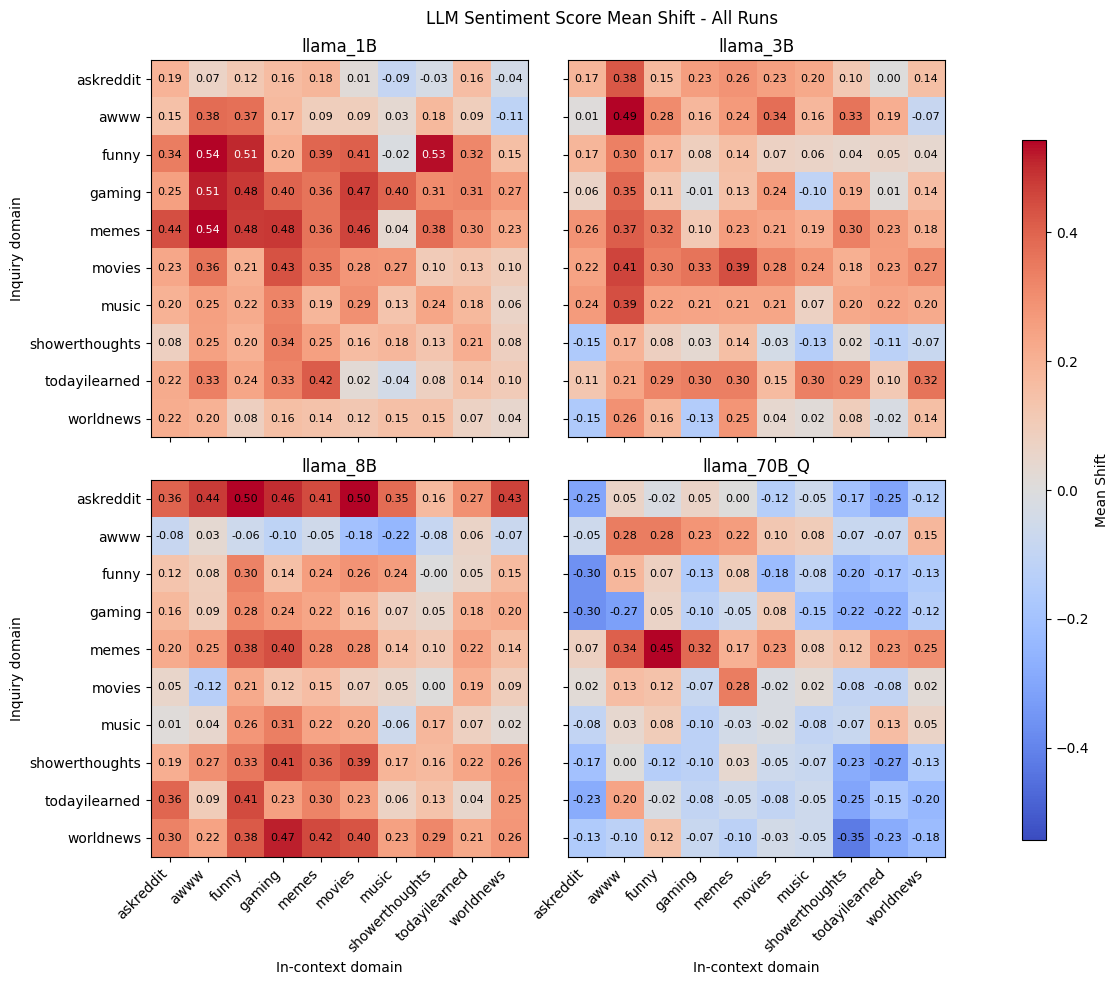

In [153]:
# aggregate over runs
run_df = mean_df.drop('run', axis=1).groupby(['model', 'inquiry_domain', 'in_context_domain']).mean().reset_index()

# plot the mean shift for each model
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'LLM Sentiment Score Mean Shift - All Runs')

# Plot the heatmaps for each model
images = []
for i, model_name in enumerate(model_names):
    ax = axs[i // 2, i % 2]
    model_data = run_df[(run_df['model'] == model_name)]
    im = plot_heatmap(model_data, model_name, ax, plot_col='mean_shift_llm')
    images.append(im)

# Add a colorbar that applies to all subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(images[0], cax=cbar_ax, label='Mean Shift')

plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()

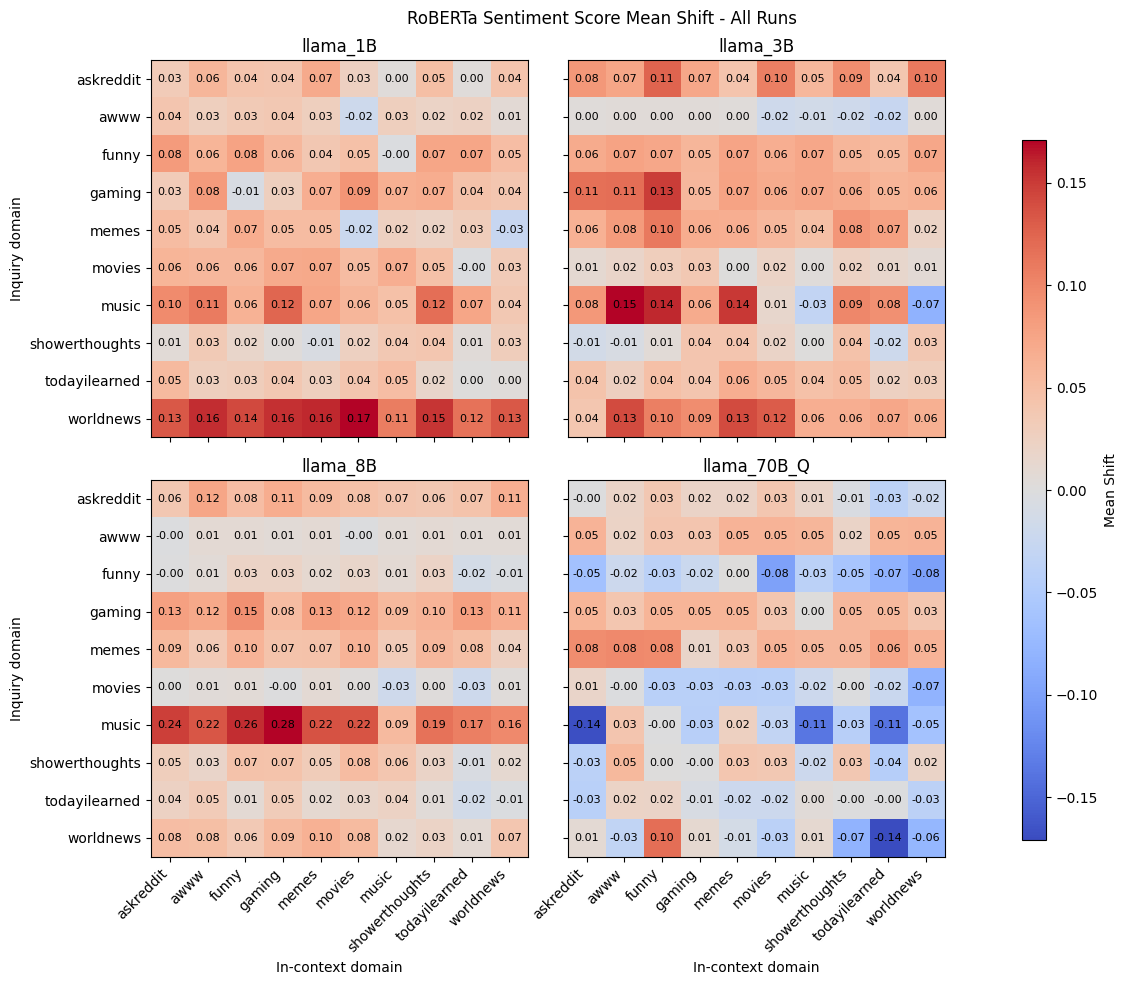

In [154]:
# plot the mean shift for each model
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'RoBERTa Sentiment Score Mean Shift - All Runs')

# Plot the heatmaps for each model
images = []
for i, model_name in enumerate(model_names):
    ax = axs[i // 2, i % 2]
    model_data = run_df[(run_df['model'] == model_name)]
    im = plot_heatmap(model_data, model_name, ax, plot_col='mean_shift_bert')
    images.append(im)

# Add a colorbar that applies to all subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(images[0], cax=cbar_ax, label='Mean Shift')

plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()

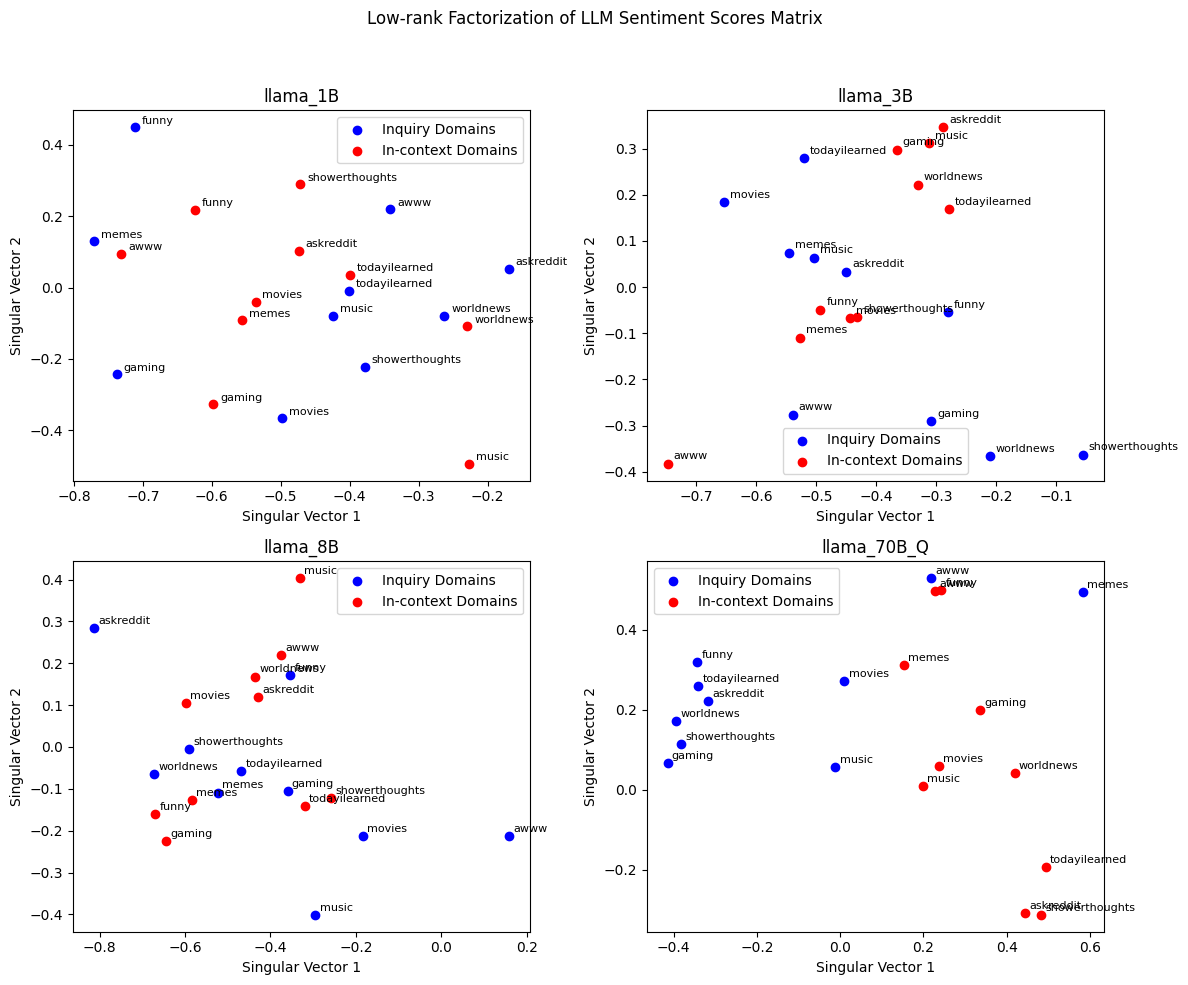

In [159]:
# perform low-rank matrix factorization on the sentiment scores, to determine which in-context domains are the most similar
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for i, model_name in enumerate(model_names):
    model_df = run_df[(run_df['model'] == model_name)]
    pt = pd.pivot_table(model_df, index='inquiry_domain', columns='in_context_domain', values='mean_shift_llm')
    icds = list(pt.columns)
    iqds = list(pt.index)
    U, S, Vt = np.linalg.svd(pt.to_numpy(), full_matrices=False)

    # get the top 2 singular vectors
    inquiry_vectors = U[:, :2] * np.sqrt(S[:2])
    in_context_vectors = Vt[:2, :].T * np.sqrt(S[:2])

    # plot the singular vectors
    ax = axs[i // 2, i % 2]
    ax.scatter(inquiry_vectors[:, 0], inquiry_vectors[:, 1], label='Inquiry Domains', color='blue')
    ax.scatter(in_context_vectors[:, 0], in_context_vectors[:, 1], label='In-context Domains', color='red')
    offset = 0.01
    for j, txt in enumerate(iqds):
        ax.annotate(txt, (inquiry_vectors[j, 0] + offset, inquiry_vectors[j, 1] + offset), fontsize=8)
    for j, txt in enumerate(icds):
        ax.annotate(txt, (in_context_vectors[j, 0] + offset, in_context_vectors[j, 1] + offset), fontsize=8)
    
    # set the title and labels
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Singular Vector 1')
    ax.set_ylabel('Singular Vector 2')
    ax.legend()
    # ax.label_outer()

plt.suptitle('Low-rank Factorization of LLM Sentiment Scores Matrix')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
    

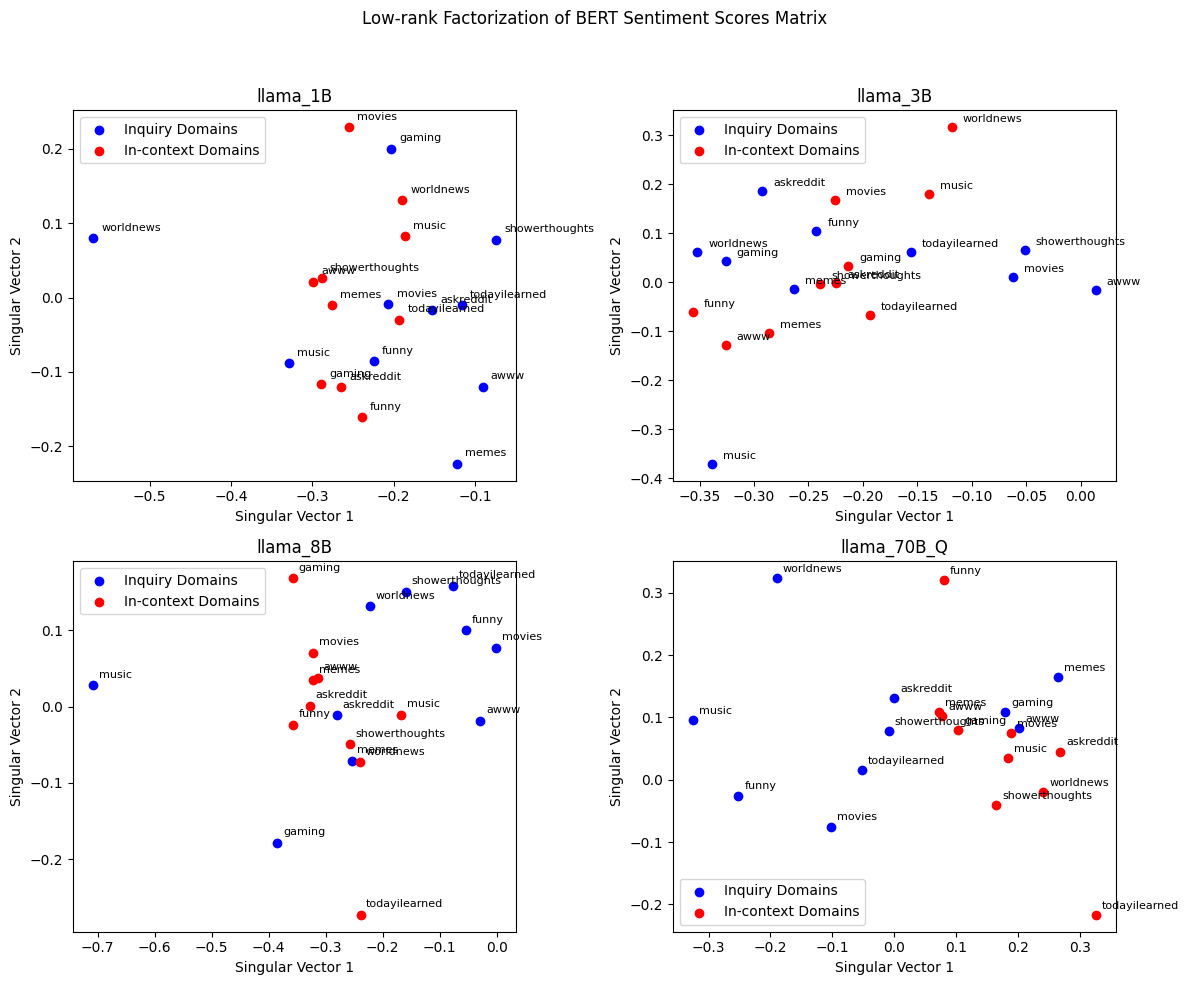

In [160]:
# perform low-rank matrix factorization on the sentiment scores, to determine which in-context domains are the most similar
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for i, model_name in enumerate(model_names):
    model_df = run_df[(run_df['model'] == model_name)]
    pt = pd.pivot_table(model_df, index='inquiry_domain', columns='in_context_domain', values='mean_shift_bert')
    icds = list(pt.columns)
    iqds = list(pt.index)
    U, S, Vt = np.linalg.svd(pt.to_numpy(), full_matrices=False)

    # get the top 2 singular vectors
    inquiry_vectors = U[:, :2] * np.sqrt(S[:2])
    in_context_vectors = Vt[:2, :].T * np.sqrt(S[:2])

    # plot the singular vectors
    ax = axs[i // 2, i % 2]
    ax.scatter(inquiry_vectors[:, 0], inquiry_vectors[:, 1], label='Inquiry Domains', color='blue')
    ax.scatter(in_context_vectors[:, 0], in_context_vectors[:, 1], label='In-context Domains', color='red')
    offset = 0.01
    for j, txt in enumerate(iqds):
        ax.annotate(txt, (inquiry_vectors[j, 0] + offset, inquiry_vectors[j, 1] + offset), fontsize=8)
    for j, txt in enumerate(icds):
        ax.annotate(txt, (in_context_vectors[j, 0] + offset, in_context_vectors[j, 1] + offset), fontsize=8)
    
    # set the title and labels
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Singular Vector 1')
    ax.set_ylabel('Singular Vector 2')
    ax.legend()
    # ax.label_outer()

plt.suptitle('Low-rank Factorization of BERT Sentiment Scores Matrix')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
    

In [161]:
run_df

,model,inquiry_domain,in_context_domain,inq_doc_idx,sentiment_score_prior,score_onehot_prior,sentiment_score,score_onehot,mean_shift_llm,mean_shift_bert,kl_div_llm,kl_div_bert
0,llama_1B,askreddit,askreddit,9.500000,"[0.11406581116529803, 0.885934189558029]","[0.043333333333333335, 0.25, 0.446666666666666...","[0.08195295221327493, 0.9180470553193785]","[0.0, 0.2233333333333333, 0.4633333333333333, ...",0.193333,0.032113,14.734513,0.720598
1,llama_1B,askreddit,awww,9.500000,"[0.11406581116529803, 0.885934189558029]","[0.043333333333333335, 0.25, 0.446666666666666...","[0.055664735031702245, 0.9443352700822287]","[0.04666666666666667, 0.22666666666666666, 0.4...",0.066667,0.058401,11.987237,0.543922
2,llama_1B,askreddit,funny,9.500000,"[0.11406581116529803, 0.885934189558029]","[0.043333333333333335, 0.25, 0.446666666666666...","[0.07160578675568104, 0.928394210646705]","[0.04, 0.24000000000000002, 0.4066666666666667...",0.116667,0.042460,13.319001,0.599405
3,llama_1B,askreddit,gaming,9.500000,"[0.11406581116529803, 0.885934189558029]","[0.043333333333333335, 0.25, 0.446666666666666...","[0.07306826314656063, 0.9269317310253004]","[0.010000000000000002, 0.22666666666666668, 0....",0.163333,0.040998,15.423041,0.659560
4,llama_1B,askreddit,memes,9.614035,"[0.116640626975037, 0.8833593728981519]","[0.045087719298245614, 0.2526315789473684, 0.4...","[0.047107862054080324, 0.9528921394913228]","[0.006666666666666667, 0.2319298245614035, 0.4...",0.184211,0.069533,13.443385,0.564716
...,...,...,...,...,...,...,...,...,...,...,...,...
395,llama_8B,worldnews,movies,9.500000,"[0.1257797262976722, 0.8742202662614483]","[0.03666666666666667, 0.44333333333333336, 0.3...","[0.04090114365913905, 0.959098856812343]","[0.006666666666666667, 0.22333333333333336, 0....",0.396667,0.084879,15.172014,0.731363
396,llama_8B,worldnews,music,9.500000,"[0.1257797262976722, 0.8742202662614483]","[0.03666666666666667, 0.44333333333333336, 0.3...","[0.10603591696126387, 0.8939640857279301]","[0.0033333333333333335, 0.32666666666666666, 0...",0.226667,0.019744,12.323778,0.722278
397,llama_8B,worldnews,showerthoughts,9.500000,"[0.1257797262976722, 0.8742202662614483]","[0.03666666666666667, 0.44333333333333336, 0.3...","[0.09244194127580461, 0.9075580547501643]","[0.0033333333333333335, 0.31666666666666665, 0...",0.290000,0.033338,11.638832,0.450411
398,llama_8B,worldnews,todayilearned,9.500000,"[0.1257797262976722, 0.8742202662614483]","[0.03666666666666667, 0.44333333333333336, 0.3...","[0.11202795568543177, 0.8879720499770096]","[0.02, 0.32666666666666666, 0.4000000000000001...",0.210000,0.013752,10.203611,0.645841


In [162]:
mean_df

,run,model,inquiry_domain,in_context_domain,inq_doc_idx,sentiment_score_prior,score_onehot_prior,sentiment_score,score_onehot,mean_shift_llm,mean_shift_bert,kl_div_llm,kl_div_bert
0,long,llama_1B,askreddit,askreddit,9.5,"[0.07993877698318101, 0.9200612217187881]","[0.0, 0.35, 0.35, 0.25, 0.05]","[0.10254706226987764, 0.8974529470084235]","[0.0, 0.3, 0.45, 0.2, 0.05]",0.00,-0.022608,20.723266,0.998547
1,long,llama_1B,askreddit,awww,9.5,"[0.07993877698318101, 0.9200612217187881]","[0.0, 0.35, 0.35, 0.25, 0.05]","[0.05192622055765241, 0.9480737858742941]","[0.05, 0.15, 0.45, 0.15, 0.2]",0.30,0.028013,16.578613,0.813448
2,long,llama_1B,askreddit,funny,9.5,"[0.07993877698318101, 0.9200612217187881]","[0.0, 0.35, 0.35, 0.25, 0.05]","[0.05461793633876368, 0.9453820521186571]","[0.05, 0.25, 0.45, 0.2, 0.05]",-0.05,0.025321,16.578613,0.775805
3,long,llama_1B,askreddit,gaming,9.5,"[0.07993877698318101, 0.9200612217187881]","[0.0, 0.35, 0.35, 0.25, 0.05]","[0.051416183734545484, 0.9485838212189265]","[0.0, 0.2, 0.5, 0.2, 0.1]",0.20,0.028523,19.341715,0.846427
4,long,llama_1B,askreddit,memes,9.5,"[0.07993877698318101, 0.9200612217187881]","[0.0, 0.35, 0.35, 0.25, 0.05]","[0.05434806621051393, 0.9456519261351787]","[0.0, 0.15, 0.45, 0.25, 0.15]",0.40,0.025591,19.341715,0.775709
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,short,llama_8B,worldnews,movies,9.5,"[0.16276336836628616, 0.8372366118431092]","[0.01, 0.48, 0.31000000000000005, 0.17, 0.0300...","[0.014825712488964199, 0.9851742815971374]","[0.02, 0.17, 0.4600000000000001, 0.32, 0.03000...",0.44,0.147938,6.832613,0.754209
1196,short,llama_8B,worldnews,music,9.5,"[0.16276336836628616, 0.8372366118431092]","[0.01, 0.48, 0.31000000000000005, 0.17, 0.0300...","[0.02366481013596058, 0.9763351798057556]","[0.01, 0.23000000000000004, 0.4699999999999999...",0.33,0.139099,7.958761,0.587273
1197,short,llama_8B,worldnews,showerthoughts,9.5,"[0.16276336836628616, 0.8372366118431092]","[0.01, 0.48, 0.31000000000000005, 0.17, 0.0300...","[0.07224991249386221, 0.9277500700950622]","[0.01, 0.25000000000000006, 0.4700000000000000...",0.32,0.090513,4.522373,0.353434
1198,short,llama_8B,worldnews,todayilearned,9.5,"[0.16276336836628616, 0.8372366118431092]","[0.01, 0.48, 0.31000000000000005, 0.17, 0.0300...","[0.0838455674983561, 0.9161544346809387]","[0.01, 0.33, 0.4000000000000001, 0.21000000000...",0.23,0.078918,2.979812,0.157126


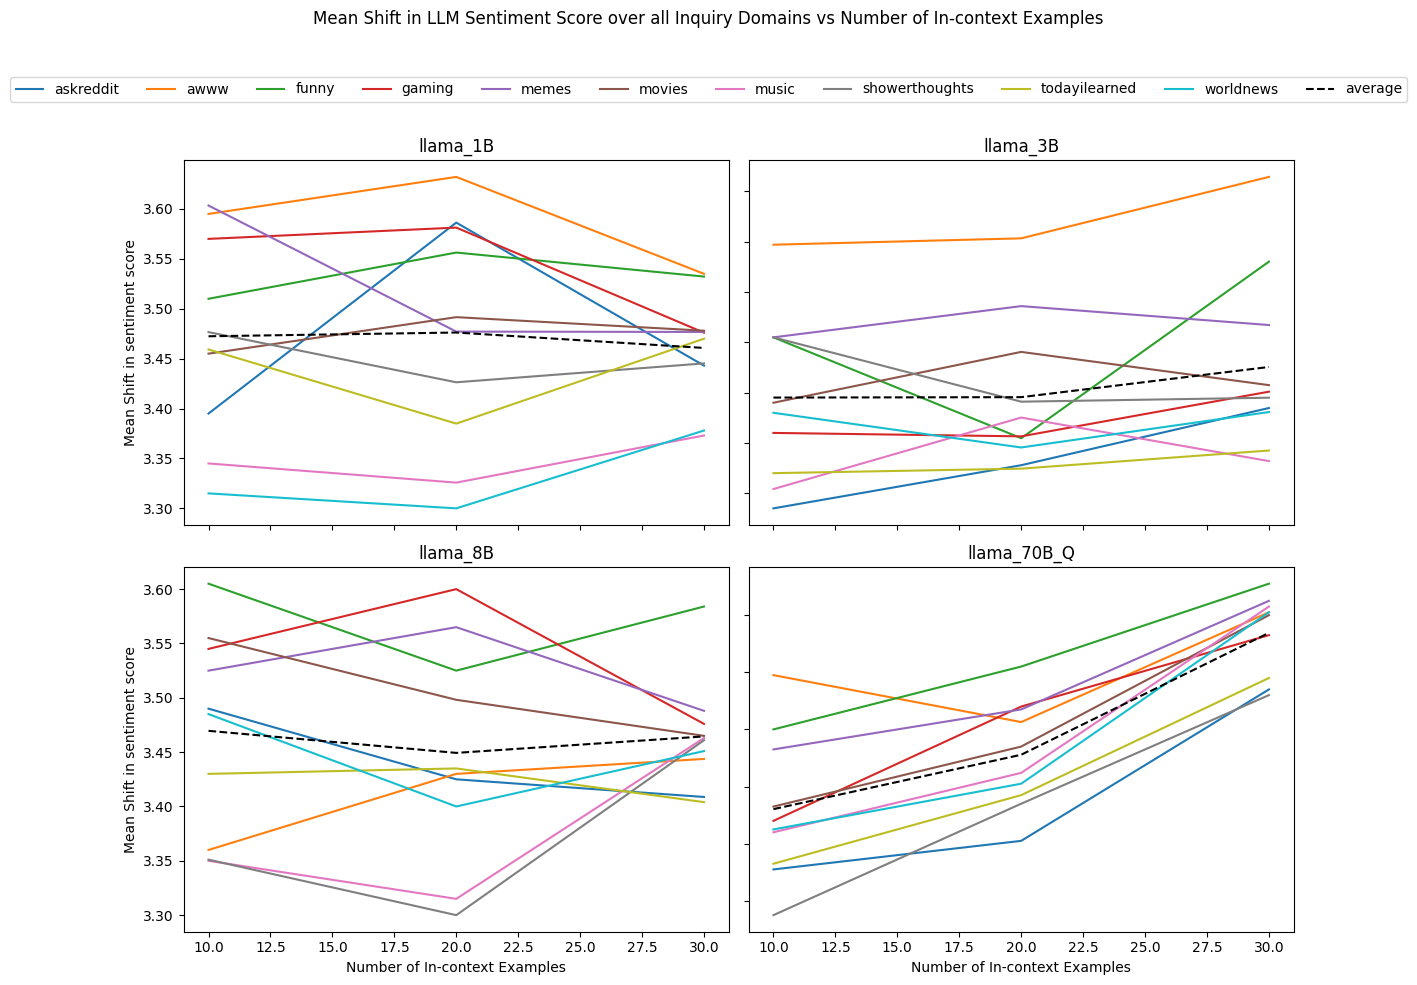

In [172]:
# add a column to mean_df that is the weighted sum of 'score_onehot' with weights [1, 2, 3, 4, 5]
mean_df['weighted_score'] = np.sum(np.vstack(mean_df['score_onehot']) * np.array([1, 2, 3, 4, 5]), axis=1)

# plot the average sentiment score for each inquiry domain for each model vs the number of in-context examples
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Store lines and labels for the common legend
lines = []
labels = []

for idx, model_name in enumerate(model_names):
    model_df = mean_df[mean_df['model'] == model_name]
    runs = pd.pivot_table(model_df, index='run', columns='in_context_domain', values='weighted_score')
    ax = axes[idx // 2, idx % 2]
    data = runs.values
    
    # Plot all the lines without labels (for the individual subplots)
    domain_lines = []
    for j in range(data.shape[1]):
        line, = ax.plot([10, 20, 30], data[:, j])
        # Only store the lines and labels from the first subplot for the legend
        if idx == 0:
            lines.append(line)
            labels.append(runs.columns[j])
    
    # Plot the average line
    avg_line, = ax.plot([10, 20, 30], np.mean(data, axis=1), linestyle='--', color='black')
    if idx == 0:
        lines.append(avg_line)
        labels.append('average')
    
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Number of In-context Examples')
    ax.set_ylabel('Mean Shift in sentiment score')
    ax.label_outer()

# Add the title
plt.suptitle('Mean Shift in LLM Sentiment Score over all Inquiry Domains vs Number of In-context Examples')

# Create a single legend below the title but above the subplots
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=len(labels))

# Adjust layout to make room for the legend at the top
plt.tight_layout(rect=[0, 0, 1, 0.90])

# Show the plot
plt.show()

In [ ]:
# we ran 52800 trials in total

,in_context_domain,inquiry_domain,in_context_doc_indices,inq_doc_idx,question_order,output_instance_number,gen_time,model_answer,n_input_tokens,n_output_tokens,justification,score,model,run,sentiment_score,score_onehot
0,funny,funny,"[98, 84, 55, 49, 39, 53, 36, 37, 87, 45]",0,[0],1,7.439453,"Based on the provided content chunks, here are...",3494,475,"The sentiment of this response is neutral, as ...",3.0,llama_1B,short,"[0.001225372, 0.9987746]","[0.0, 0.0, 1.0, 0.0, 0.0]"
1,funny,funny,"[98, 84, 55, 49, 39, 53, 36, 37, 87, 45]",0,[0],2,2.382785,"Based on your previous content consumption, it...",3494,263,The response maintains a neutral tone by focus...,3.0,llama_1B,short,"[0.0020683303, 0.9979317]","[0.0, 0.0, 1.0, 0.0, 0.0]"
2,funny,funny,"[98, 84, 55, 49, 39, 53, 36, 37, 87, 45]",0,[0],3,3.923434,"Based on the NEW content chunk, here are the m...",3494,437,The response maintains a neutral tone througho...,3.0,llama_1B,short,"[0.0011751619, 0.9988248]","[0.0, 0.0, 1.0, 0.0, 0.0]"
3,funny,funny,"[98, 84, 55, 49, 39, 53, 36, 37, 87, 45]",0,[0],4,1.503070,"Based on the NEW content chunk, the main takea...",3494,165,The response maintains a neutral tone througho...,3.0,llama_1B,short,"[0.001267359, 0.9987326]","[0.0, 0.0, 1.0, 0.0, 0.0]"
4,funny,funny,"[98, 84, 55, 49, 39, 53, 36, 37, 87, 45]",0,[0],5,2.556063,"Based on your prior content consumption, I've ...",3494,284,The overall sentiment of this response is neut...,4.0,llama_1B,short,"[0.002352792, 0.9976472]","[0.0, 0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52795,music,showerthoughts,"[53, 92, 27, 38, 36, 47, 12, 96, 55, 57, 16, 9...",19,[0],1,11.736152,The main takeaways from this NEW content chunk...,20980,370,The overall tone of the chatbot's response is ...,4.0,llama_8B,long,"[0.0015855018, 0.9984145]","[0.0, 0.0, 0.0, 1.0, 0.0]"
52796,memes,showerthoughts,"[38, 68, 7, 82, 62, 23, 92, 91, 63, 54, 9, 77,...",19,[0],1,8.741449,"Based on the NEW content chunk, the main takea...",15436,311,"The response presents a neutral tone, providin...",4.0,llama_8B,long,"[0.0013136207, 0.9986864]","[0.0, 0.0, 0.0, 1.0, 0.0]"
52797,movies,showerthoughts,"[23, 16, 66, 3, 13, 40, 33, 6, 88, 90, 67, 37,...",19,[0],1,7.749717,The main takeaway from this NEW content chunk ...,25219,188,The response presents a generally positive and...,4.0,llama_8B,long,"[0.001753459, 0.99824655]","[0.0, 0.0, 0.0, 1.0, 0.0]"
52798,showerthoughts,showerthoughts,"[16, 19, 48, 60, 53, 66, 59, 10, 75, 72, 95, 4...",19,[0],1,12.436308,"Based on the NEW content chunk, the main takea...",24728,355,The sentiment of this response is clearly posi...,5.0,llama_8B,long,"[0.0015632102, 0.99843675]","[0.0, 0.0, 0.0, 0.0, 1.0]"
